# Purpose and plan

In this project, I will attempt to estimate the height of an individual based on their weight, gender, and BMI. I will implement Keras for the machine learning part of this assignment, and use Pandas and Matplotlib for data explotation.

# Setup

First, I'll import all needed libraries, and set things up so that this project should run smoothly on as many machines as possible. We also want to plot figures inline, so I'll use the built in Jupyter-Notebook magic for that.

In [72]:
# make sure we can support Python 2
from __future__ import division, print_function, unicode_literals

# import our necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
import os

# Plot figures in the notebook with Jupyter-Notebook magic
%matplotlib inline

# give everything a random seed so that we get repeatable results.
seed_value= 42

os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

Time to import data from our CSV file! The file is named "HeightWeightData.csv," nd is stored in the same directory as this notebook. 

In [73]:
# create paths for the loading of data, and the saving of images.
DATA_PATH = "./HeightWeightData.csv"

if not os.path.exists("Figures"):
    os.makedirs("Figures")

FIGURE_PATH = "./Figures/"

# Exploring and visualizing the data:

Based on the online description of the dataset, the data should be structured as follows:

    Gender : Male / Female

    Height : Number (cm)

    Weight : Number (Kg)

    Index :

        0 - Extremely Weak

        1 - Weak

        2 - Normal

        3 - Overweight

        4 - Obesity

        5 - Extreme Obesity
        
Now, just to make sure that there are no surprises, let's check out the data after importing it into a pandas DataFrame: 

In [74]:
data = pd.read_csv(DATA_PATH)

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
Gender    500 non-null object
Height    500 non-null int64
Weight    500 non-null int64
Index     500 non-null int64
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


,Height,Weight,Index
count,500.000000,500.000000,500.000000
mean,169.944000,106.000000,3.748000
std,16.375261,32.382607,1.355053
min,140.000000,50.000000,0.000000
25%,156.000000,80.000000,3.000000
50%,170.500000,106.000000,4.000000
75%,184.000000,136.000000,5.000000
max,199.000000,160.000000,5.000000


There is a single categorical data column to deal with. Let's explore what it contains, and in what amounts:

In [75]:
print(data["Gender"].value_counts())

Female    255
Male      245
Name: Gender, dtype: int64


Now we'll get some more information on how non-categorical features are spread out with the handy pandas hist() method.

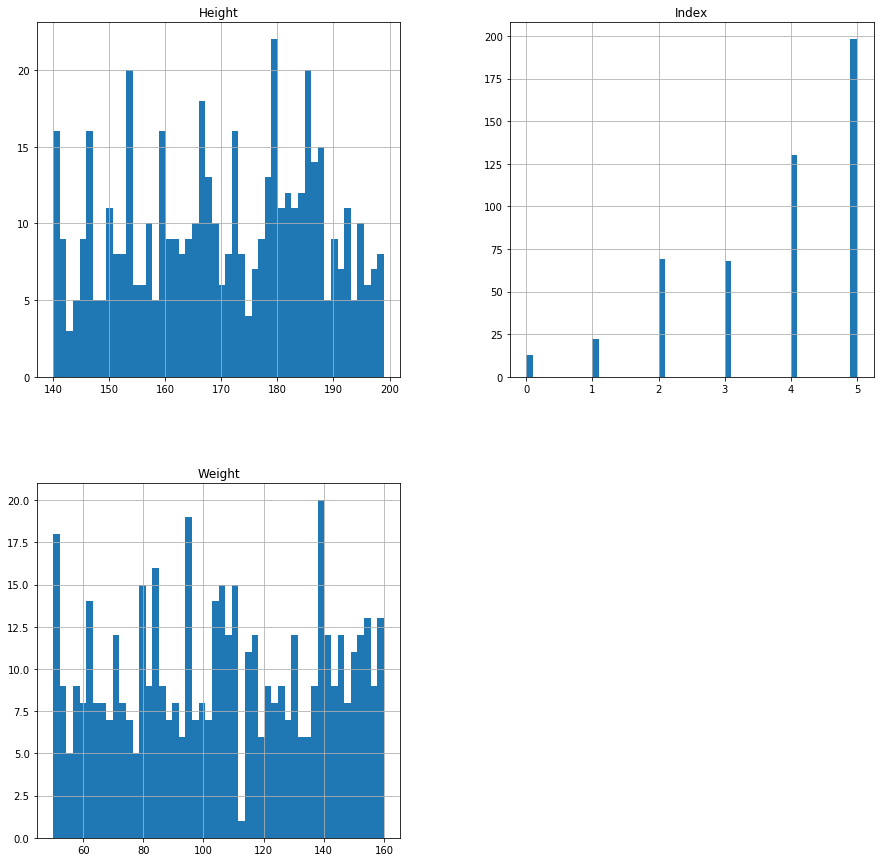

In [76]:
data.hist(bins=50, figsize = [15, 15])
plt.show()

Because the hist() mehtod ignores categorical data, I'll just grab the value_counts of each variable in the "Gender" column, and plot those so that we have all variables visualized.

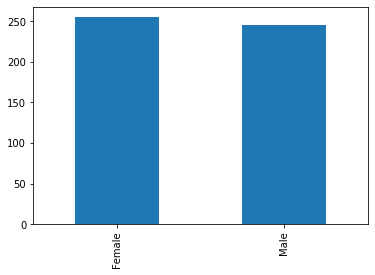

In [77]:
data["Gender"].value_counts().plot(kind="bar")#can't hist() on categorical.
plt.show()

What I've noticed so far is:

1) The data has buit in ratios. There are more females than males in the data, and there are a lot more people in the BMI "5" range than the other ranges. This will require some stratified splitting later if we want to avoid random sampling bias in the training/test sets.

2) There appears to be an obvious relationship between weight and height. I think the reason that the histogram for height and the histogram for weight are jumpy is the fact that there are only 500 instances in this set. I'm definately seeing parallels between the amount of people in a certain range of height, and the amount of people in a certain range of weight. If there were more instances, I think we'd see a much smoother top to the graph. (That smoothness doesn't have to be a straight line, of course.)

# Process the data for machine learning:
As I mentioned previousely, we will need to be carefule when splitting up the data. I need the test/train matrices of features, (Index, Gender, and Weight,) and labels, (Height.) I also need to come up with a way to deal with the categorical data. This means that the first order of business is to throw the "Gender" column into a one-hot encoder in order to avoid the problems of false correlation that an ordinal encoder would cause.

In [78]:
#quick encoder I wrote because I was having difficulty with the Scikit-Learn encoders.
def one_hot_gender(array):
    return_array = []
    for i in range(0, len(array)):
        if array[i] == "Male":
            return_array.append([0, 1])
        else:
            return_array.append([1, 0])
    return return_array

In [79]:
gender = data["Gender"].to_numpy()
data = data.drop(["Gender"], axis=1)
gender_encoded =one_hot_gender(gender)
data["Gender"] = gender_encoded
print(data.head())

   Height  Weight  Index  Gender
0     174      96      4  [0, 1]
1     189      87      2  [0, 1]
2     185     110      4  [1, 0]
3     195     104      3  [1, 0]
4     149      61      3  [0, 1]


I'll be doing stratified splitting of the data based around the "Index" feature, because it has the most variance, and I think it will have more effect than something like "Gender" in which the spread is fairly even. The docs for scikit-learn say that the y parameter in the StratifiedShuffleSplit method is supposed to be the target variable in the data, so I guess this is a bit of an experiment.

In [93]:
from sklearn.model_selection import StratifiedShuffleSplit #import the splitter

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(data, data["Index"]):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

Now that I've split the data up, I'd like to make sure that everything worked out. I'll make a get_info() method to check out the shape and 'head' of a data subset, and I'll create some histograms to compare the 'Index' columns' spread between the different data sets.

In [94]:
def get_info(dframe, name):
    print("---------------------------------")
    print(name)
    print("")
    print("shape: " + str(np.shape(dframe)))
    print("")
    print(dframe.head())
    print("")

In [95]:
#make sure everything went smoothly with the splitting:    
get_info(train_set, "train_set")
get_info(test_set, "test_set")

---------------------------------
train_set

shape: (400, 4)

     Height  Weight  Index  Gender
262     156     137      5  [0, 1]
486     160     109      5  [1, 0]
360     193      61      1  [1, 0]
483     146      85      4  [0, 1]
309     171     141      5  [0, 1]

---------------------------------
test_set

shape: (100, 4)

     Height  Weight  Index  Gender
348     178     138      5  [0, 1]
36      197     114      3  [1, 0]
0       174      96      4  [0, 1]
81      166     140      5  [1, 0]
102     161     155      5  [0, 1]



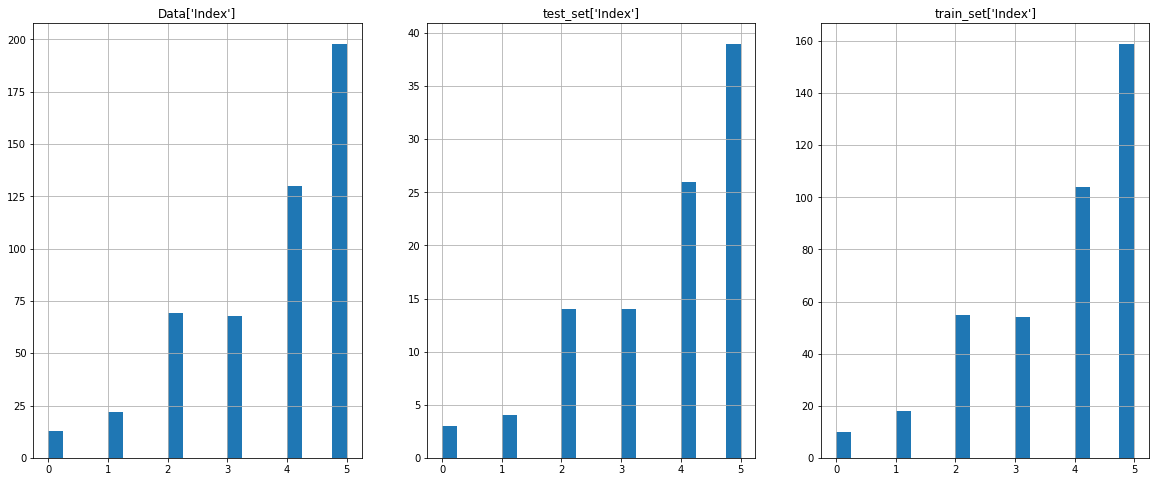

In [139]:
fig = plt.figure(figsize=(20, 8))

dataIndex = fig.add_subplot(1, 3, 1)
data["Index"].hist(bins=20)
dataIndex.title.set_text("Data['Index']")

testIndex = fig.add_subplot(1, 3, 2)
test_set["Index"].hist(bins=20)
testIndex.title.set_text("test_set['Index']")


trainIndex = fig.add_subplot(1, 3, 3)
train_set["Index"].hist(bins=20)
trainIndex.title.set_text("train_set['Index']")

plt.show()

I'm content with how those turned out, so I'll move on to creating the label/feature subsets, as well as a validation data subset.

# Prepare the machine learning algorithm

Now that the data is ready for machine learning, I will use Keras to create a feedforward neural network with densly connected layers.